In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/test.csv
/kaggle/input/titanic/train.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
#import training data
Train = pd.read_csv("/kaggle/input/titanic/train.csv")
train_df = Train.drop(['PassengerId','Survived'], axis=1)
label = Train['Survived']
Train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [3]:
#Test data for Kaggle score
Test = pd.read_csv("/kaggle/input/titanic/test.csv")
test_df = Test.drop(['PassengerId'], axis=1)

# Data Preprocessing

Sex

In [4]:
#map to numeric values
#male: 1, female: 0
train_df['Sex'] = train_df['Sex'].map(lambda x: 1 if(x=='male') else 0)
test_df['Sex'] = test_df['Sex'].map(lambda x: 1 if(x=='male') else 0)

Embarked

In [5]:
#fill empty value with mode
#C:0, Q:1, S:2
train_df['Embarked'].fillna(train_df['Embarked'].mode(), inplace=True)
train_df['Embarked']=train_df['Embarked'].apply(lambda x: 0 if x=='C' else(1 if x=='Q' else 2) )

test_df['Embarked'].fillna(test_df['Embarked'].mode(), inplace=True)
test_df['Embarked']=test_df['Embarked'].apply(lambda x: 0 if x=='C' else(1 if x=='Q' else 2) )

Cabin

In [6]:
#extract the letter from Cabin and fill empty value with the mode('C')
nonEmpty = train_df[train_df['Cabin'].isna()==False]['Cabin']
nonEmpty = nonEmpty.apply(lambda x: x[0])
nonEmpty.mode()
train_df['Cabin'] = train_df['Cabin'].fillna('C')
train_df['Cabin']=train_df['Cabin'].apply(lambda x: x[0])
dict_1 = {'A':0, 'B':1, 'C':2, 'D':3, 'E':4, 'F':5, 'G':6, 'T':7 }
train_df['Cabin']=train_df['Cabin'].apply(lambda x: dict_1[x])

In [7]:
#mapping function to numeric values

dict_1 = {'A':0, 'B':1, 'C':2, 'D':3, 'E':4, 'F':5, 'G':6, 'T':7 }
test_df['Cabin'] = test_df['Cabin'].fillna('C')
test_df['Cabin']=test_df['Cabin'].apply(lambda x: x[0])
test_df['Cabin']=test_df['Cabin'].apply(lambda x: dict_1[x])

Age

In [8]:
#Fill na of Age with mean value

train_df.loc[train_df['Sex']==1,'Age'] = train_df.loc[train_df['Sex']==1,'Age'].fillna(30.726645)
train_df.loc[train_df['Sex']==0,'Age'] = train_df.loc[train_df['Sex']==0,'Age'].fillna(27.915709)

test_df.loc[test_df['Sex']==1,'Age'] = test_df.loc[test_df['Sex']==1,'Age'].fillna(30.272362)
test_df.loc[test_df['Sex']==0,'Age'] = test_df.loc[test_df['Sex']==0,'Age'].fillna(30.272732)


Fare

In [9]:
#Fill na of Fare with median
test_df['Fare'].fillna(test_df['Fare'].median(), inplace = True)

Name

In [10]:
#extract the title of name, and map to numeric values
title_series = train_df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
title_dict = {'Capt':5,
 'Col':4,
 'Countess':4,
 'Don':4,
 'Dona':4,
 'Dr':4,
 'Jonkheer':4,
 'Lady':4,
 'Major':4,
 'Master':4,
 'Miss':1,
 'Mlle':1,
 'Mme':2,
 'Mr':0,
 'Mrs':2,
 'Ms':1,
 'Rev':4,
 'Sir':4}
title_series=title_series.map(title_dict)
train_df['Title'] = title_series
train_df.drop('Name',axis=1,inplace=True)

title_series = test_df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
title_series=title_series.map(title_dict)
test_df['Title'] = title_series
test_df.drop('Name',axis=1,inplace=True)


Ticket Number

In [11]:
#drop ticket number
train_df.drop('Ticket', axis=1, inplace=True )
test_df.drop('Ticket', axis=1, inplace=True )


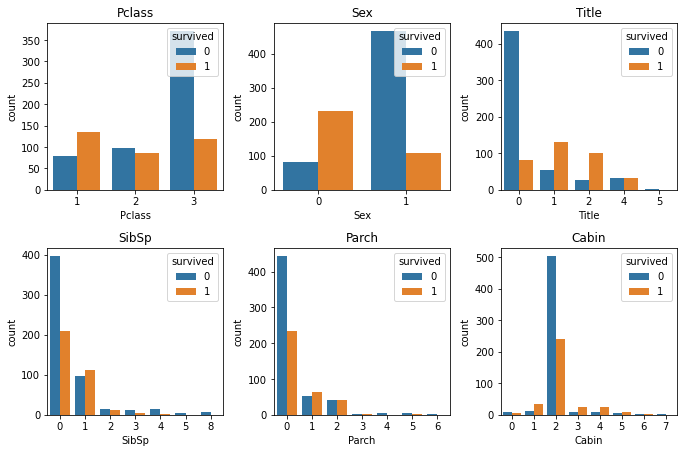

In [12]:
# Visualize the count of survivors for columns 'Pclass', 'Sex', 'Title','Sibsp', 'Parch', and 'Cabin'
cols = ['Pclass', 'Sex', 'Title', 'SibSp', 'Parch', 'Cabin']

n_rows = 2
n_cols = 3

fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*3.2,n_rows*3.2))

for r in range(0,n_rows):
    for c in range(0,n_cols):  
        
        i = r*n_cols+ c      
        ax = axs[r][c] 
        sns.countplot(train_df[cols[i]], hue=label, ax=ax)
        ax.set_title(cols[i])
        ax.legend(title="survived", loc='upper right') 
        
plt.tight_layout() 

# Model training - Logistic Regression

In [13]:
#cross validation
from sklearn.model_selection import cross_val_score
clf = LogisticRegression(max_iter=10000)
clf.fit(train_df, label)
scores = cross_val_score(clf, train_df, label, cv=10, scoring = "accuracy")
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Scores: [0.81111111 0.84269663 0.75280899 0.84269663 0.80898876 0.76404494
 0.82022472 0.83146067 0.83146067 0.83146067]
Mean: 0.8136953807740325
Standard Deviation: 0.029787150485548832


# Evaluation

Confusion Matrix

In [14]:
#confusion matrix
y_prob = clf.predict_proba(train_df)
df_matrix = pd.DataFrame({'True label': label,
                    'Predicted label': y_prob[:,1] > 0.5})

df_matrix.replace(to_replace={0:'No', 1:'Yes', 'True':'Yes', 'False':'No'}, inplace=True)
df_matrix.groupby(['Predicted label','True label']).size().unstack('True label')

True label,No,Yes
Predicted label,,
No,477,89
Yes,72,253


In [15]:
#function to plot confusion matrix
def plot_confusion_matrix(cm, title='Confusion matrix (Normalized)',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Normalized confusion matrix')
    plt.colorbar()
    plt.tight_layout()
    plt.xlabel('True label',rotation='horizontal', ha='right')
    plt.ylabel('Predicted label')
    plt.show()

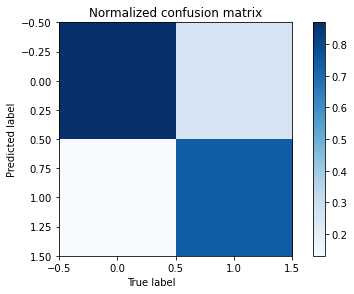

array([[0.86885246, 0.26023392],
       [0.13114754, 0.73976608]])

In [16]:
#plot confusion matrix of training data
cm = confusion_matrix(label, y_prob[:,1] > 0.5)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plot_confusion_matrix(cm_normalized.T)
cm_normalized.T

ROC curve

In [17]:
#calculate false positive and true positive rate for ROC curve
false_pos_rate, true_pos_rate, _ = roc_curve(label, y_prob[:,1])
roc_auc = auc(false_pos_rate, true_pos_rate)


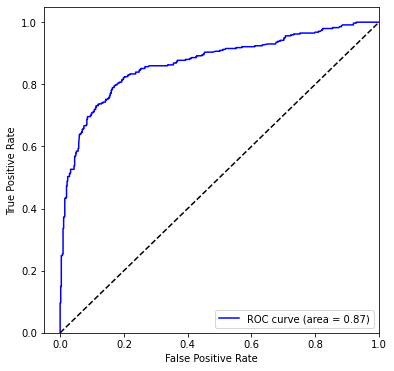

In [18]:
#plot ROC curve
fig, ax1 = plt.subplots(1, 1, figsize=(6,6))
ax1.plot(false_pos_rate, true_pos_rate, label='ROC curve (area = %0.2f)' % roc_auc, color='b')

for ax in fig.axes:
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([-0.05, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc="lower right")

# Model Training - Random Forest

In [23]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)
model.fit(train_df, label)

#generate cross validation score
scores = cross_val_score(model, train_df, label, cv=10, scoring = "accuracy")
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

#Generate confusion matrix
y_prob2 = model.predict_proba(train_df)
df_matrix = pd.DataFrame({'True label': label,'Predicted label': y_prob2[:,1] > 0.5})
df_matrix.replace(to_replace={0:'No', 1:'Yes', 'True':'Yes', 'False':'No'}, inplace=True)
df_matrix.groupby(['Predicted label','True label']).size().unstack('True label')

Scores: [0.82222222 0.88764045 0.75280899 0.88764045 0.86516854 0.82022472
 0.83146067 0.79775281 0.85393258 0.83146067]
Mean: 0.8350312109862672
Standard Deviation: 0.03919178148116636


True label,No,Yes
Predicted label,,
No,511,84
Yes,38,258


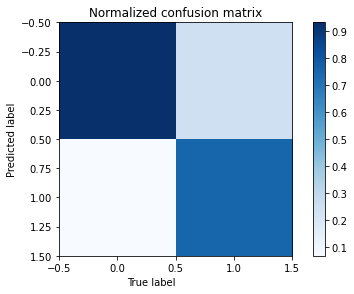

array([[0.93078324, 0.06921676],
       [0.24561404, 0.75438596]])

In [20]:
#Plot confusion matrix
cm2 = confusion_matrix(label, y_prob2[:,1] > 0.5)
cm_normalized = cm2.astype('float') / cm2.sum(axis=1)[:, np.newaxis]
plot_confusion_matrix(cm_normalized.T)
cm_normalized

In [21]:
#calculate false positive rate, true positive rate for ROC curve
false_pos_rate, true_pos_rate, _ = roc_curve(label, y_prob2[:,1])
roc_auc = auc(false_pos_rate, true_pos_rate)

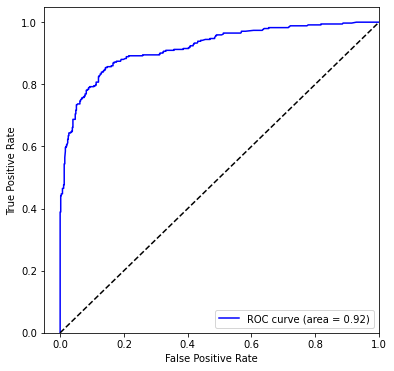

In [22]:
#Plot ROC curve
fig, ax1 = plt.subplots(1, 1, figsize=(6,6))
ax1.plot(false_pos_rate, true_pos_rate, label='ROC curve (area = %0.2f)' % roc_auc, color='b')

for ax in fig.axes:
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([-0.05, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc="lower right")